In [31]:
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dydx3.constants import MARKET_DOGE_USD
from dydx3 import Client
from web3 import Web3

from sklearn.preprocessing import StandardScaler
from emd.sift import sift

In [32]:
scale = StandardScaler()

In [33]:
data = pd.read_csv('BTC_1min.csv',)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [34]:
p = np.array(data['Close'])
p_idx = data['Close']
p_scaled = scale.fit_transform(p.reshape(-1,1))

In [35]:
def getPCA(m):
    """
    Gets the Eigenvalues and Eigenvector values from the Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation Matrix
    Returns:
        (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation Matrix
            np.ndarray: Eigenvectors of correlation Matrix
    """
    # Get eVal, eVec from a Hermitian Matrix
    eVal, eVec = np.linalg.eigh(m)
    indicies = eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal, eVec = eVal[indicies], eVec[:, indicies]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [36]:
def emd_pca(p_scaled):
    imf = sift(p_scaled)
    cov = np.cov(imf.T)
    vals, vecs = getPCA(cov)

    # get explained variance
    sum_eig_val = np.sum(vals)
    explained_var = vals / sum_eig_val
    var_percent = np.round(np.diag(explained_var),1)*100
    n_comps = np.count_nonzero(var_percent)
    print(var_percent)
    reconstruct = np.dot(imf, vecs[:, :n_comps])
    rec = np.dot(reconstruct, vecs[:, :n_comps].T)
    p_reconstructed = scale.inverse_transform(np.sum(rec,1).reshape(-1,1))
    
    return p_reconstructed.reshape(1,-1).squeeze()

In [26]:
dydx_base = 'https://api.dydx.exchange'
asset = 'BTC'

In [27]:
client = Client(host=dydx_base)

In [28]:
# load dydx data
dydx_candle = client.public.get_candles(market=asset.upper()+'-USD')
dydx_asset= pd.DataFrame((dydx_candle.data)['candles'])
dydx_asset['startedAt'] = dydx_asset['startedAt'].str.slice(0, 16)
dydx_asset['startedAt'] =pd.to_datetime(dydx_asset['startedAt'], format='%Y-%m-%dT%H:%M:%S')
dydx_asset.set_index('startedAt', inplace=True)
dydx_asset['close'] = pd.to_numeric(dydx_asset['close'], errors='coerce')

In [29]:
dydx_asset

,updatedAt,market,resolution,low,high,open,close,baseTokenVolume,trades,usdVolume,startingOpenInterest
startedAt,,,,,,,,,,,
2023-03-20 19:48:00,2023-03-20T19:48:46.039Z,BTC-USD,1MIN,27879,27896,27896,27896,5.5139,55,153770.9236,4015.7967
2023-03-20 19:47:00,2023-03-20T19:47:59.283Z,BTC-USD,1MIN,27891,27923,27921,27902,6.4193,56,179108.273,4012.5547
2023-03-20 19:46:00,2023-03-20T19:46:56.261Z,BTC-USD,1MIN,27873,27918,27889,27918,14.1396,103,394411.506,4010.8222
2023-03-20 19:45:00,2023-03-20T19:45:57.862Z,BTC-USD,1MIN,27882,27908,27902,27889,2.6681,28,74441.3466,4007.3526
2023-03-20 19:45:00,2023-03-20T19:48:46.039Z,BTC-USD,15MINS,27873,27923,27902,27896,28.7409,242,801732.0492,4007.3526
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20 18:35:00,2023-03-20T18:35:59.206Z,BTC-USD,1MIN,27980,28004,27997,27990,10.7047,86,299674.3033,3966.8523
2023-03-20 18:35:00,2023-03-20T18:39:59.397Z,BTC-USD,5MINS,27964,28040,27997,28004,70.842,514,1983081.129,3966.8523
2023-03-20 18:34:00,2023-03-20T18:34:52.511Z,BTC-USD,1MIN,27982,28035,28009,28000,12.7835,108,358056.4109,3965.8472


In [212]:
# load gemini data
secret_key = "BAxYeS5iigF6M9eRqUv3guVLq35"
asset = 'ETH'
gemini_base = "https://api.gemini.com"

gemini_candle = requests.get(gemini_base + "/v2" + "/candles/"+asset+"usd/1m")

In [213]:
gemini_data = pd.DataFrame(gemini_candle.json(), columns=['Date','Open','High','Low','Close','Volume'])
gemini_data['Date'] = pd.to_datetime(gemini_data['Date']/1000, unit='s')
gemini_data.set_index('Date',inplace=True)

gemini_p = np.array(gemini_data['Close'])
gemini_p_scaled = scale.fit_transform(gemini_p.reshape(-1,1))

In [39]:
p_reconstructed = emd_pca(p_scaled)

[90. 10.  0.  0.  0.  0.  0.  0.  0.  0.]


In [41]:
df = pd.DataFrame({'reconstructed': p_reconstructed}, index = data.index)
df['diff'] = data['Close'] - df['reconstructed']
threshold = df['diff'].std() * 1

<AxesSubplot:ylabel='Frequency'>

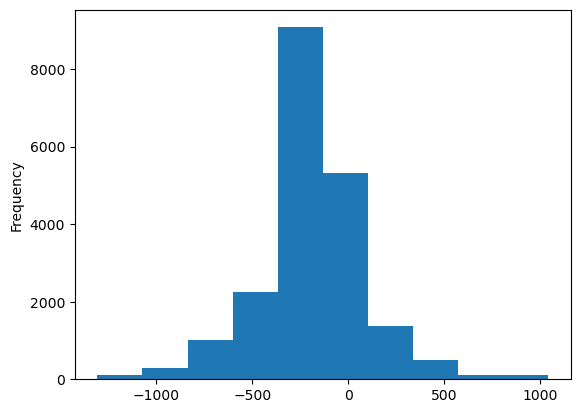

In [42]:
df['diff'].plot(kind='hist')

In [43]:
df['position'] = np.where(df['diff'] > threshold, -1, np.nan)
df['position'] = np.where(df['diff'] < threshold, 1, df['position'])
df['position'] = np.where(df['diff'] * df['diff'].shift(1) < 0, 0, df['position'])
df['position'] = df['position'].ffill().fillna(0)

In [45]:
df['price'] = data['Close']
df['returns'] = np.log(df['price'] / df['price'].shift(1))
df['strategy'] = df['position'].shift(1) * df['returns']

In [60]:
shares = .01
transaction_costs = 0.01

<AxesSubplot:xlabel='Date'>

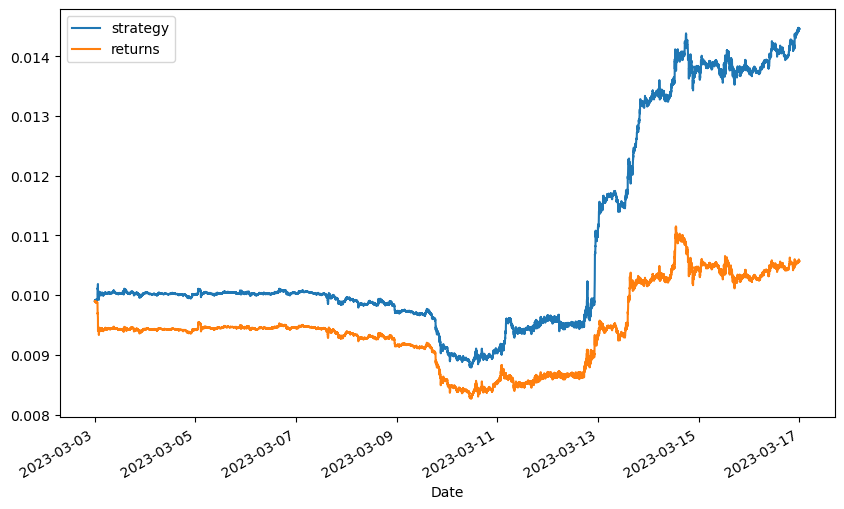

In [61]:
(df[['strategy','returns']].dropna().cumsum().apply(np.exp)*shares*(1-transaction_costs)).plot(figsize=(10,6))

In [62]:
short_x = (df['position'] < 0).to_numpy().nonzero()[0]
short = ((df['position'] < 0) * df['price'])
short_y = short[short != 0]

long_x = (df['position'] > 0).to_numpy().nonzero()[0]
long = ((df['position'] > 0) * df['price'])
long_y = long[long != 0]

In [63]:
positions = -short + long

In [64]:
# if there is a cluster of trades make toegther, only execute the first of the cluster
# this way we will not over-leverage out positions
short_ = True
long_ = True
s = np.zeros_like(df['price'])
l = np.zeros_like(df['price'])
for i in range(len(df['price'])):
    if positions.iloc[i] < 0:
        if short_:
            s[i] = True
            short_ = False
            long_ = True
    if positions.iloc[i] > 0:
        if long_:
            l[i] = True
            long_ = False
            short_ = True

In [65]:
positions = l * df['price'] - s * df['price']

In [66]:
long_x = df['price'].index[df['price'] * l != 0]
long_y = df['price'][l>0]

short_x = df['price'].index[df['price'] * s != 0]
short_y = df['price'][s>0]

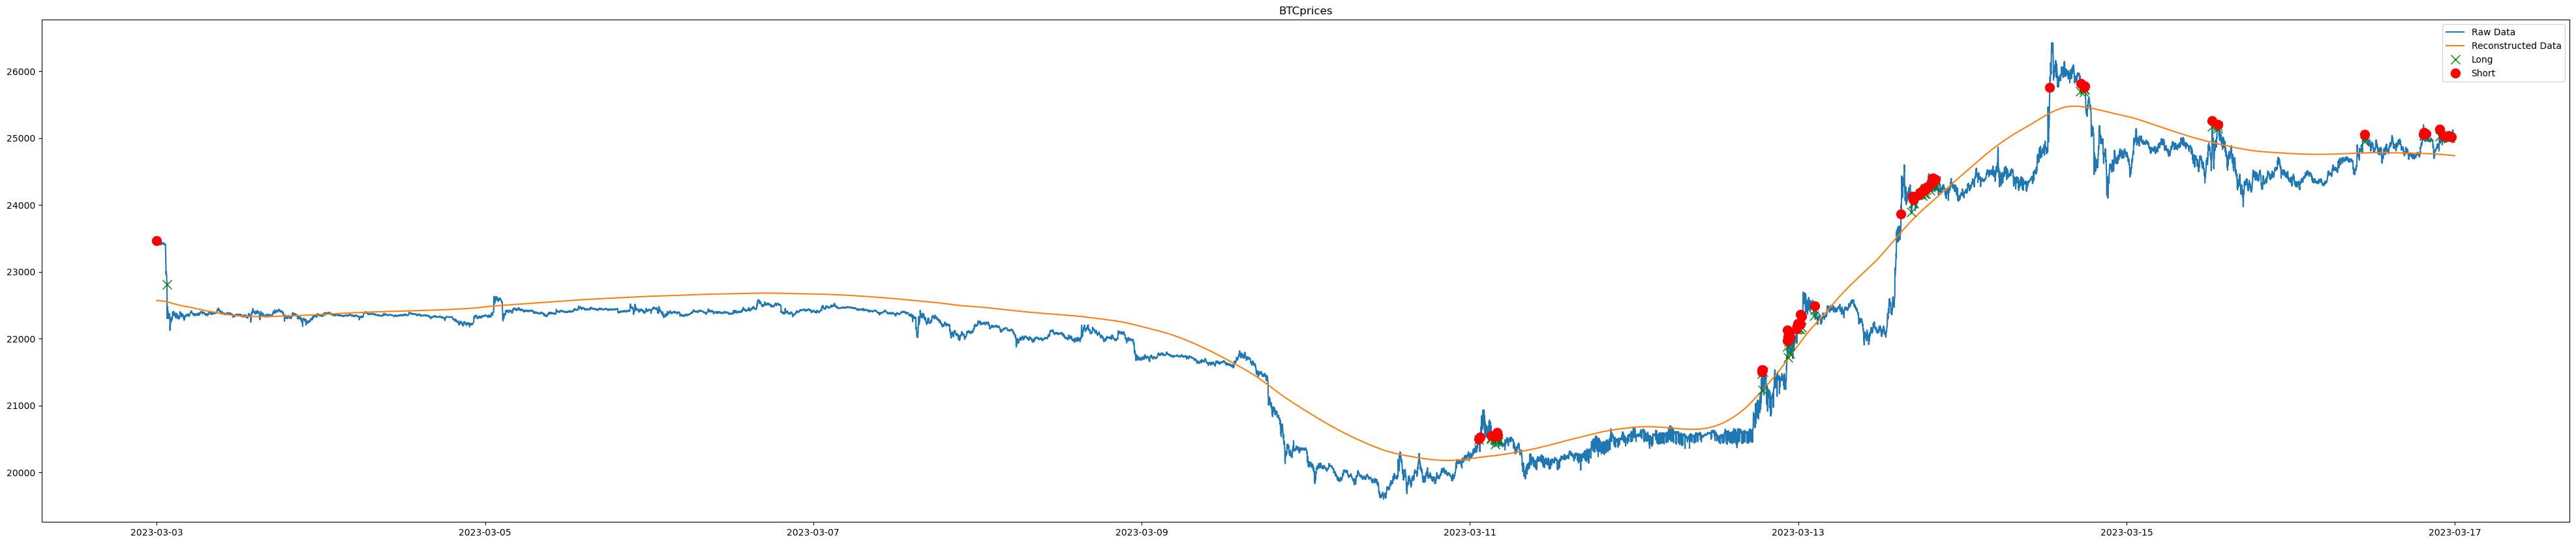

In [67]:
#start_date = '2023-03-11 00:00:00'
fig = plt.figure(figsize=(50,10))
plt.plot(df['price'], label = 'Raw Data')
plt.plot(df['reconstructed'], label = 'Reconstructed Data')
plt.plot(long_x, long_y, "x", color = 'green', markersize=10, label = "Long")
plt.plot(short_x, short_y, "o", color = 'red', markersize=10, label = "Short")
plt.title(asset+"prices")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

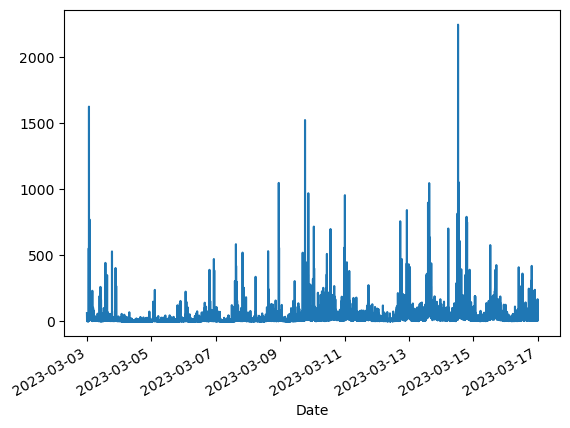

In [68]:
data['Volume'].plot()

In [69]:
trades = positions[positions != 0]

In [70]:
if len(trades) % 2 != 0:
    trades = trades[1:]

In [71]:
pnl = np.sum(shares*-trades)

In [72]:
pnl

59.81079999999909